# DL2 - Sheet 09: Advanced XAI (100 points)



In [1]:
# Install the transformers library if neccessary
# ! pip install transformers


# Exercise 1) Better explanations for Transformers  (60 points)

## Preparation: From sentences to tokens

First, we will use hugginface's tokenizer to go from words to indices in the vocabulary. In the following, we will focus on the distilBERT model:


In [2]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import numpy as np
import matplotlib.pyplot as plt
from torch import nn, Tensor
from typing import Any

class Identity(nn.Identity):
    """A layer that just returns Zero-Embeddings"""

    def __init__(self, dim=768, *args: Any, **kwargs: Any) -> None:
        self.dim = dim
        super().__init__()

    def forward(self, input_ids: Tensor,  inputs_embeds: Tensor) -> Tensor:
        return inputs_embeds 


def plot_sentence(tokens, relevance):
    f,ax = plt.subplots(1,1)
    ax.imshow(relevance/np.max(np.abs(relevance)), vmin=-1, vmax=1, cmap='coolwarm')
    ax.set_xticks(range(len(subtokens)))
    ax.set_xticklabels(tokens, rotation=45)
    plt.show()


tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

sentence = "A really great movie."
inputs = tokenizer(sentence, return_tensors = 'pt')
subtokens = tokenizer.convert_ids_to_tokens(list(inputs['input_ids'].squeeze()))

print(inputs)


{'input_ids': tensor([[ 101, 1037, 2428, 2307, 3185, 1012,  102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]])}


# 1.1) Compute the naive model gradient (Gradient x Input)  (20 points)

Implement the computation of the model gradient. Since we want to compute the gradient w.r.t. to the embedded tokens (instead of the input ids), we need to first break down the computation of the forward pass:


- 1) Compute the token embeddings and prepare an 'inputs_' dictionary that uses the embeddings instead of input_ids. Forward these into the model to collect the logits (10p)
- 2) Now, for the explanations, compute the gradient w.r.t. the selected logit. Compute the GradientxInput explanation and plot the relevance over input tokens (10p).

tensor([[-4.3113,  4.6659]], grad_fn=<AddmmBackward0>)
tensor([[-4.3113,  4.6659]], grad_fn=<AddmmBackward0>)


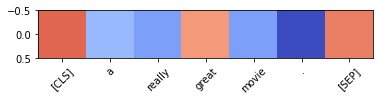

In [3]:
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

if not isinstance(model.distilbert.embeddings, Identity):
    # Bypass embeddings module and use pre-computed embeddings instead 
    # To do this we extract the token embeddings module before bypassing
    embeddings_module = model.distilbert.embeddings
    model.distilbert.embeddings = Identity()
    
### START 1. compute embeddings and prepare inputs_ dict ###
inputs_ = {k:v for k,v in inputs.items()}
embeddings_out = embeddings_module(inputs_['input_ids'])
inputs_['inputs_embeds'] = embeddings_out 
del inputs_['input_ids']
inputs_['input_ids'] = None
logits = model(**inputs_).logits
### END ###

print(logits)

# Start computation of gradient
embeddings_ = embeddings_out.detach().requires_grad_(True)

inputs_xai = {k:v for k,v in inputs_.items()}
inputs_xai['inputs_embeds'] = embeddings_

logits = model(inputs_embeds=inputs_xai['inputs_embeds']).logits
print(logits)

# Select what signal to propagate back through the network
### START 2. Compute gradient and GradientxInput ###
class_idx = 1
selected_logit = logits[:, class_idx]
selected_logit.backward()
gradient = embeddings_.grad
relevance = gradient*embeddings_
relevance_gi = relevance.sum(2).detach().cpu().numpy()
### END 2. ###


plot_sentence(subtokens, relevance_gi)

# 1.2) Implementing LRP explanations for Transformers (20 points)

- 1. Implement the layer norm forward pass. Compute the mean and standard deviations to normalize the inputs. Detach the appropriate terms to ensure conservation. (5p)
- 2. Modify the self-attention forward pass to be relevance conserving. (5p)
- 3. Implement the rule for the gelu activation function. (5p)
     Hint: modify the forward pass such that: $h = x \cdot [(gelu(x)/x)]_{cst.}$
- 4. Compute the LRP explanation and plot the relevance over tokens for again GradientxInput in comparison to LRP. (5p)

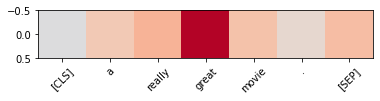

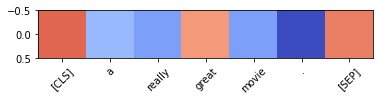

In [4]:
# Define LRP model
import math
from typing import Union, Optional, Tuple, Dict

from transformers.modeling_outputs import SequenceClassifierOutput, CausalLMOutputWithCrossAttentions
from transformers.models.distilbert.modeling_distilbert import DistilBertForSequenceClassification, MultiHeadSelfAttention
import torch

DEVICE =  'cpu'

class LayerNormXAI(nn.Module):
    __constants__ = ['weight', 'bias', 'eps']

    def __init__(self, hidden, eps=1e-5, elementwise_affine=True, args=None, dtype=None):
                
        factory_kwargs = {'device': DEVICE, 'dtype': dtype}
        super(LayerNormXAI, self).__init__()
        self.mode = 'distilnorm'
        self.sigma = None
        self.hidden = hidden
        if self.mode == 'no_norm':
            elementwise_affine = False
        self.eps = eps
        self.elementwise_affine = elementwise_affine
        if self.elementwise_affine:
            self.weight = nn.Parameter(torch.empty(self.hidden, **factory_kwargs))
            self.bias = nn.Parameter(torch.empty(self.hidden, **factory_kwargs))
        else:
            self.register_parameter('weight', None)
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        if self.elementwise_affine:
            nn.init.ones_(self.weight)
            nn.init.zeros_(self.bias)

    def forward(self, input):
        if self.mode == 'no_norm':
            return input
       
        elif self.mode == 'distilnorm':
            
            ### Start 1: Compute mean and std, detach appropriate terms ###
            mean = input.mean(dim=-1, keepdim=True)
            std = torch.sqrt(((input - mean) ** 2).sum(dim=-1, keepdims=True) / input.shape[-1])
            input_norm = (input - mean) / (std.detach() + self.eps)
            ### End ###
            
            input_norm = input_norm * self.weight + self.bias

            return input_norm

        else:
            raise


def LayerNorm(normalized_shape, eps=1e-5, elementwise_affine=True, export=False, args=None):
    if args is not None:
        if args.lnv != 'origin':
            return LayerNormImpl(hidden=normalized_shape, args=args, eps=eps, elementwise_affine=elementwise_affine)
    if not export and torch.cuda.is_available():
        try:
            from apex.normalization import FusedLayerNorm
            return FusedLayerNorm(normalized_shape, eps, elementwise_affine)
        except ImportError:
            pass
        

class MultiHeadSelfAttentionXAI(MultiHeadSelfAttention):
    def __init__(self, config):
        super().__init__(config)
        
    def forward(
        self,
        query: torch.Tensor,
        key: torch.Tensor,
        value: torch.Tensor,
        mask: torch.Tensor,
        head_mask: Optional[torch.Tensor] = None,
        output_attentions: bool = False,
    ) -> Tuple[torch.Tensor, ...]:
        """
        Parameters:
            query: torch.tensor(bs, seq_length, dim)
            key: torch.tensor(bs, seq_length, dim)
            value: torch.tensor(bs, seq_length, dim)
            mask: torch.tensor(bs, seq_length)

        Returns:
            weights: torch.tensor(bs, n_heads, seq_length, seq_length) Attention weights context: torch.tensor(bs,
            seq_length, dim) Contextualized layer. Optional: only if `output_attentions=True`
        """
        bs, q_length, dim = query.size()
        k_length = key.size(1)
        # assert dim == self.dim, f'Dimensions do not match: {dim} input vs {self.dim} configured'
        # assert key.size() == value.size()

        dim_per_head = self.dim // self.n_heads

        mask_reshp = (bs, 1, 1, k_length)

        def shape(x: torch.Tensor) -> torch.Tensor:
            """separate heads"""
            return x.view(bs, -1, self.n_heads, dim_per_head).transpose(1, 2)

        def unshape(x: torch.Tensor) -> torch.Tensor:
            """group heads"""
            return x.transpose(1, 2).contiguous().view(bs, -1, self.n_heads * dim_per_head)

        q = shape(self.q_lin(query))  # (bs, n_heads, q_length, dim_per_head)
        k = shape(self.k_lin(key))  # (bs, n_heads, k_length, dim_per_head)
        v = shape(self.v_lin(value))  # (bs, n_heads, k_length, dim_per_head)

        q = q / math.sqrt(dim_per_head)  # (bs, n_heads, q_length, dim_per_head)
        scores = torch.matmul(q, k.transpose(2, 3))  # (bs, n_heads, q_length, k_length)
        mask = (mask == 0).view(mask_reshp).expand_as(scores)  # (bs, n_heads, q_length, k_length)
        scores = scores.masked_fill(
            mask, torch.tensor(torch.finfo(scores.dtype).min)
        )  # (bs, n_heads, q_length, k_length)

        weights = nn.functional.softmax(scores, dim=-1)  # (bs, n_heads, q_length, k_length)
        weights = self.dropout(weights)  # (bs, n_heads, q_length, k_length)

        # Mask heads if we want to
        if head_mask is not None:
            weights = weights * head_mask

        
        ### Start 2 ####
        weights = weights.detach()
        ### END ####
            
        context = torch.matmul(weights, v)  # (bs, n_heads, q_length, dim_per_head)
        context = unshape(context)  # (bs, q_length, dim)
        context = self.out_lin(context)  # (bs, q_length, dim)

        if output_attentions:
            return (context, weights)
        else:
            return (context,)

                
class GELUActivationXAI(nn.Module):
    """
    Original Implementation of the GELU activation function in Google BERT repo when initially created. For
    information: OpenAI GPT's GELU is slightly different (and gives slightly different results): 0.5 * x * (1 +
    torch.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * torch.pow(x, 3)))) This is now written in C in nn.functional
    Also see the Gaussian Error Linear Units paper: https://arxiv.org/abs/1606.08415
    """

    def __init__(self):
        super().__init__()
        self.act = self._gelu_python

    def _gelu_python(self, input: Tensor) -> Tensor:
        return input * 0.5 * (1.0 + torch.erf(input / math.sqrt(2.0)))

    def forward(self, input: Tensor) -> Tensor:
        ### Start 3 ###
        func = self.act(input)
        out = input*((func/(input+1e-6)).detach())
        ### End ###
        return out
        

class DistilBertForSequenceClassificationXAI(DistilBertForSequenceClassification):
    def __init__(self, config):
        super().__init__(config)
   
        self.override_default_layers(config)

        
    def override_default_layers(self, config):
        
        for i in range(config.n_layers):
            
            self.distilbert.transformer.layer[i].attention = MultiHeadSelfAttentionXAI(config)
        
            self.distilbert.transformer.layer[i].sa_layer_norm = LayerNormXAI((config.hidden_size,), eps=config.layer_norm_eps) 
             
            self.distilbert.transformer.layer[i].output_layer_norm = LayerNormXAI((config.hidden_size,), eps=config.layer_norm_eps)             
            
            self.distilbert.transformer.layer[i].ffn.activation = GELUActivationXAI()

            
# Set-up explainable model            
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")
_ = model.eval()
config = model.config
config.layer_norm_eps = 1e-12
    
model_xai = DistilBertForSequenceClassificationXAI(config)
model_xai.load_state_dict(model.state_dict())
_ = model_xai.eval()

if not isinstance(model_xai.distilbert.embeddings, Identity):
    embeddings_module = model_xai.distilbert.embeddings
    model_xai.distilbert.embeddings = Identity()
    
inputs_ = {k:v for k,v in inputs.items()}

### Start 4 ####
# Prepare inputs dictionary
embeddings_out = embeddings_module(inputs_['input_ids'])
inputs_['input_ids'] = None
embeddings_ = embeddings_out.detach().requires_grad_(True)

inputs_xai = {k:v for k,v in inputs_.items()}
inputs_xai['inputs_embeds'] = embeddings_

# Compute forward pass
logits = model_xai(inputs_embeds=inputs_xai['inputs_embeds']).logits

# Select what signal to propagate back through the network
selected_logit = logits[:, class_idx]
selected_logit.backward()

# Compute explanation
gradient = embeddings_.grad
relevance = gradient*embeddings_
relevance_lrp = relevance.sum(2).detach().cpu().numpy()
### End ###

plot_sentence(subtokens, relevance_lrp)
plot_sentence(subtokens, relevance_gi)


In [5]:
print(logits)

tensor([[-4.3113,  4.6659]], grad_fn=<AddmmBackward0>)


In [6]:
model(inputs['input_ids']).logits

tensor([[-4.3113,  4.6659]], grad_fn=<AddmmBackward0>)

# Exercise 2) GNN-LRP explanations (40 points)

In the second exercise, we are going to compute higher-order graph explanations. A structure of a graph is defined by its adjacency matrix that contains the information about existing  nodes and egdes. In the forward pass of a GNN this structure is used to extract information in order to make a prediction. 

Here we focus on a specific type of graph (scalefree BA-graphs) that dependent on a growth paramebeter show two types of graph structure: 

- class 1: Growth behavior that favors creating isolated new nodes instead of connecting to already exisitng ones. 
- class 2: Growth behavior that preferably attaches new nodes to existing ones.


After training a layered graph network on this task, we now are intersted in extracting explanations that offer insight into which features were used by the model. These higher-order explanations considered here explain in terms of walks, which means a joint set of nodes that is connected via edges.


In [7]:
# Install igraph library if necessary
# ! pip install igraph

In [8]:
import sys
import numpy
import random
import torch
import igraph
import utils
import matplotlib.pyplot as plt

 # Function to generate a BA graph
def scalefreegraph(seed=0,embed=False,growth=None):
    random = numpy.random.mtrand.RandomState(seed)
    N = 10
    A = numpy.zeros([N,N])
    A[1,0] = 1
    A[0,1] = 1
    growth = growth if growth is not None else random.randint(1,3)
    N0 = 2
    for i in range(N0,N):
        if   growth==1: tt = 1   # Barabasi-Albert 1
        elif growth==2: tt = 2   # Barabasi-Albert 2
        else:
            tt = 1 + 1*((growth-1)>random.uniform(0,1))
        p = A.sum(axis=0)/A.sum()
        for j in random.choice(N,tt,p=p,replace=False):
            A[i,j] = 1
            A[j,i] = 1
    r = random.permutation(len(A))
    A = A[r][:,r]*1.0

    # Add Self-Connections
    A = A + numpy.identity(len(A))

    # Build Data Structures
    D = A.sum(axis=1)
    L = torch.FloatTensor(A/(numpy.outer(D,D)**.5+1e-9)) # laplacian

    return {
        'adjacency':torch.FloatTensor(A),
        'laplacian':L,
        'target':growth,
        'layout':utils.layout(A,seed) if embed else None,
        'walks':utils.walks(A)
    }

# 2.1) Implementing LRP explanations for GNNs (25 points)

- 1. Complete the forward pass of the GraphNet consisting of two standard linear layers each followed by ReLU activations. (5p)
- 2. Implement LRP-gamma in the lrp() function. 
    - a) Implement gamma-modified weight matrices that reinforce positive contributions (W1p, W1p) (5p)
    - b) Compute the gamma-modified forward pass to collect activations Zp in each layer. (10p)
    - c) Select the class evidence and compute the explanations. (5p)
    

In [9]:
class GraphNet(torch.nn.Module):
    def __init__(self,d,h,c):  
        super(GraphNet, self).__init__()
        
        self.U  = torch.nn.Parameter(torch.FloatTensor(numpy.random.normal(0,d**-.5,[d,h])))
        self.W1 = torch.nn.Parameter(torch.FloatTensor(numpy.random.normal(0,h**-.5,[h,h])))
        self.W2 = torch.nn.Parameter(torch.FloatTensor(numpy.random.normal(0,h**-.5,[h,h])))
        self.V  = torch.nn.Parameter(torch.FloatTensor(numpy.random.normal(0,h**-.5,[h,c])))
        self.params = [self.U,self.W1,self.W2,self.V]
 
    def forward(self,A):
        H = torch.eye(len(A))
        H = H.matmul(self.U).clamp(min=0)
        ### Start 1 ###
        H = (A.transpose(1,0).matmul(H.matmul(self.W1))).clamp(min=0)
        H = (A.transpose(1,0).matmul(H.matmul(self.W2))).clamp(min=0)
        ### End ###
        H = H.matmul(self.V).clamp(min=0)
        return H.mean(dim=0)
        
    def lrp(self,A,gamma,l,inds):
        # compute lrp for one walk
        if inds is not None:
            j,k = inds
            Mj = torch.FloatTensor(numpy.eye(len(A))[j][:,numpy.newaxis])
            Mk = torch.FloatTensor(numpy.eye(len(A))[k][:,numpy.newaxis])

        ### Start 2a ###
        W1p = self.W1+gamma*self.W1.clamp(min=0)
        W2p = self.W2+gamma*self.W2.clamp(min=0)
        ### End ###
        
        Vp  = self.V+gamma*self.V.clamp(min=0)
        
        X = torch.eye(len(A))
        X.requires_grad_(True)

        H  = X.matmul(self.U).clamp(min=0)

        Z  = A.transpose(1,0).matmul(H.matmul(self.W1))
        ### Start 2b (W1p) ###
        Zp = A.transpose(1,0).matmul(H.matmul(W1p))
        ### End 2b ###

        H  = (Zp*(Z/(Zp+1e-6)).data).clamp(min=0)
        
        if inds is not None: H = H * Mj + (1-Mj) * (H.data)

        Z  = A.transpose(1,0).matmul(H.matmul(self.W2))
        ### Start 2b (W2p) ###
        Zp = A.transpose(1,0).matmul(H.matmul(W2p))
        ### End 2b ###
        H  = (Zp*(Z/(Zp+1e-6)).data).clamp(min=0)
        
        if inds is not None: H = H * Mk + (1-Mk) * (H.data)

        Z  = H.matmul(self.V)
        Zp = H.matmul(Vp)
        H  = (Zp*(Z/(Zp+1e-6)).data).clamp(min=0)
        
        ### Start 2c ###
        Y = H.mean(dim=0)[l]
        Y.backward()
        R = X.data*X.grad
        ### End  ###
        return R

In [10]:
# Get model weights 
! wget https://tubcloud.tu-berlin.de/s/N95ggJgTm4wjWHQ/download/gcn.pt

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
--2023-06-25 20:34:09--  https://tubcloud.tu-berlin.de/s/N95ggJgTm4wjWHQ/download/gcn.pt
Resolving tubcloud.tu-berlin.de (tubcloud.tu-berlin.de)... 141.23.34.165
Connecting to tubcloud.tu-berlin.de (tubcloud.tu-berlin.de)|141.23.34.165|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 37127 (36K) [application/octet-stream]
Saving to: ‘gcn.pt.1’

gcn.pt.1            100%[===================>]  36.26K  --.-KB/s    in 0.001s  

2023-06-25 20:34:09 (55.0 MB/s) - ‘gcn.pt.1’ saved [37127/37127]



In [11]:
# d: number of nodes
# h: hidden size of hidden node representations
# c: number of classes
model = GraphNet(d=10,h=64,c=2)
_ = model.load_state_dict(torch.load('gcn.pt'))

In [12]:
model

GraphNet()

# 2.2) Extracting LRP for each walk and plot explanations. (15 points)

- 1. Loop through walks and compute lrp for each set of indices in each walk. Hint: `graph_sample['walks']` (10p)
- 2. How do resulting explanations differ for class 1 vs class 2? Name two characteristics each. (5p)

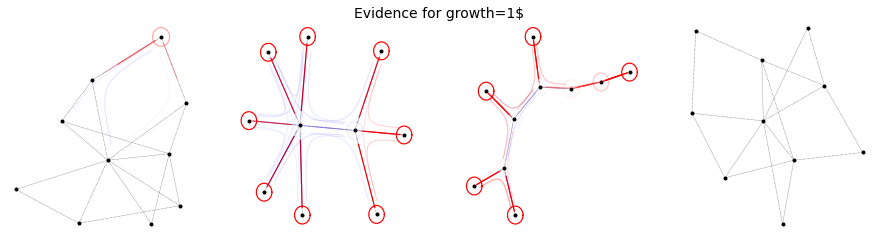

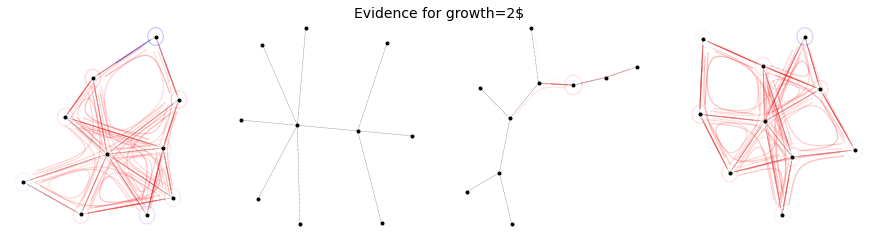

In [13]:
 def explain(g, nn, t, gamma=None, ax=None):
    # Arrange graph layout 
    r = g['layout']
    r = r - r.min(axis=0)
    r = r / r.max(axis=0) * 2 - 1
    
    # Plot the graph
    N = len(g['adjacency'])
    for i in numpy.arange(N):
        for j in numpy.arange(N):
            if g['adjacency'][i,j] > 0 and i != j: plt.plot([r[i,0],r[j,0]],[r[i,1],r[j,1]], color='gray', lw=0.5, ls='dotted')
    ax.plot(r[:,0],r[:,1],'o',color='black',ms=3)
    
    for (i,j,k) in g['walks']:
        ### Start 2.1: Loop through walks, assign correct indices to mask the LRP pass ###
        R = nn.lrp(g['laplacian'], gamma, t, (j,k))
        R = R[i].sum()
        ### End ###
        
        
        tx,ty = utils.shrink([r[i,0],r[j,0],r[k,0]],[r[i,1],r[j,1],r[k,1]])

        if R > 0.0:
            alpha = numpy.clip(20*R.data.numpy(),0,1)
            ax.plot(tx,ty,alpha=alpha,color='red',lw=1.2) 

        if R < -0.0:
            alpha = numpy.clip(-20*R.data.numpy(),0,1)
            ax.plot(tx,ty,alpha=alpha,color='blue',lw=1.2)
            
            
sample_ids = [1,3,4,5]
gamma=0.1

for target in [0,1]:
    plt.figure(figsize=(3*len(sample_ids), 3))
    for ids, seed in enumerate(sample_ids):
        ax =plt.subplot( 1,len(sample_ids), ids+1)
        graph_sample = scalefreegraph(seed=seed, embed=True)

        # Explain
        explain(graph_sample, model, target, gamma=gamma, ax=ax)
        plt.subplots_adjust(left=0,right=1,bottom=0,top=1)
        plt.axis('off')

    
    plt.suptitle('Evidence for growth={}$'.format(target+1), size=14, y=1.05)
    plt.show()
    plt.close()

### Start 2.2: How do the resulting explanations differ? ###
##### Class 1 (growth=1):  \
    - Relevance is focused on nodes via self-loops, highlighs the isolated satellite nodes that do not receive any further attaching of new nodes and are only connected to the graph via one edge connection. \
    - Results in few connections, and spread-out graphs.
    
##### Class 2 (growth=2):\
    - Relevance is primarily attributed to the edge connections instead of nodes. \
    - This highlights the interconnected structure and the behavior of attaching new nodes preferably to already existing, densly connected parts of the graph.\
    - Results in compact in dense and compact graphs.\
